**IMDB Movie Reviews Classification Using sckiti-learn**<br/>
Review Classification using traditional machine learning and nlp techniques using scikit-learn

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import itertools
from collections import Counter
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
# Load the datasets into a dataframe
imdb = pd.read_csv("IMDB.csv")
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


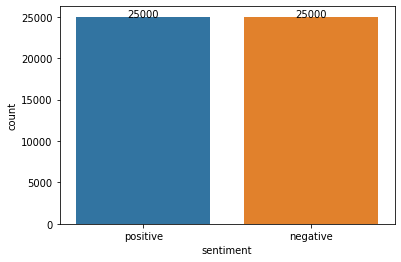

In [3]:
graph = sns.countplot(x="sentiment", data=imdb)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

We have a perfectly balanced dataset. First, let us split the data into train/validation/test sets

In [4]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(imdb['review'], imdb['sentiment'], random_state=1, test_size = 0.2)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, random_state=1, test_size = 0.2)

# Let us print the shapes after split
print("Train data shape: ", xtrain.shape)
print("Validation data shape: ", xval.shape)
print("Test data shape: ", xtest.shape)

Train data shape:  (32000,)
Validation data shape:  (8000,)
Test data shape:  (10000,)


Let us create wordclouds to find the common words used for positive and negative reviews

In [6]:
from wordcloud import WordCloud

# Method to generate word clouds
def create_wordcloud(label):
    text = xtrain[ytrain == label]
    text = ' '.join([sent for sent in text])
    wordcloud = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(text)
    plt.figure(figsize=(10, 7)) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis('off')

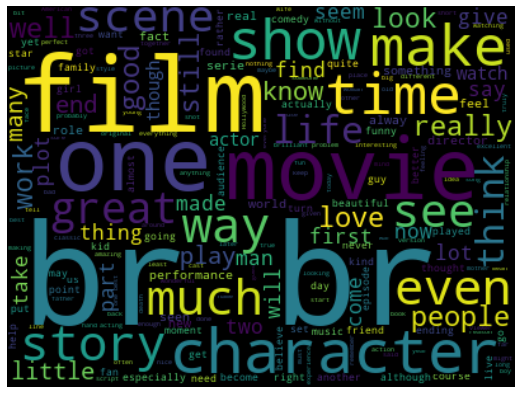

In [7]:
create_wordcloud("positive")

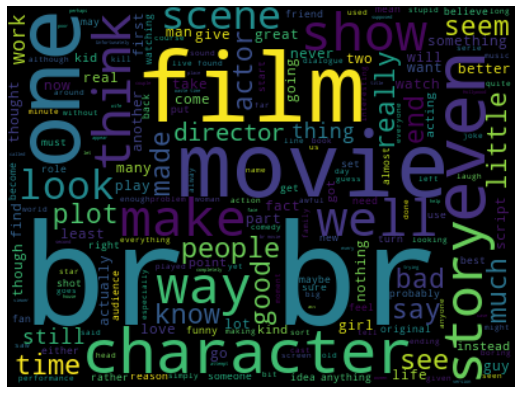

In [8]:
create_wordcloud("negative")

As we can see from the wordclouds, the common words in both the positive and negative sentences are similar and do not reveal much sentiment specific information. Thus, we must first preprocess the text and extract specific features to provide as input to the models.<br/>
We  will do the following processing<br/>
1. Lowercasing the text
2. Expand contractions like n't -> not using pycontractions library
3. Remove specific words which do not contribute largely to the sentiment. To do this, we will first pos_tag the sentence. Then remove Nouns, Pronouns, Determiners. We are not using prefined stopwords lists from the python libraries because those lists contain words like 'not', 'doesn't', etc which are useful for sentiment detection.
4. Stemming
5. Remove punctation

In [25]:
from nltk import sent_tokenize, pos_tag
#from pycontractions import Contractions
stemmer = nltk.PorterStemmer()
#cont = Contractions(api_key="glove-twitter-25")
#cont.load_models()

def preprocess_text(text):
    tags = ['NNP', 'NNPS', 'PRP', 'PRP$', 'DT', 'WDT', 'IN', 'TO']
    words = ['and', 'am', 'is', 'be']
    # lowercasing
    text = text.lower()
    sentences = sent_tokenize(text)
    
    # Expand contractions
    #expand_sent = list(cont.expand_texts(sentences, precise=True))
    
    # Remove specific words + Stemming
    cleaned_sent = ""
    for sent in sentences:        
        if sent:
            s = ' '.join([stemmer.stem(word) for word, tag in pos_tag(sent.split()) if (tag not in tags) and (word not in words)])
            cleaned_sent = cleaned_sent + s + ' '    
    
    # Remove punctuations
    cleaned_sent = re.sub("[^a-zA-Z ]", "", cleaned_sent)
    
    return cleaned_sent

In [26]:
xtrain = xtrain.apply(lambda x: preprocess_text(x))
xval = xval.apply(lambda x: preprocess_text(x))
xtest = xtest.apply(lambda x: preprocess_text(x))

In [27]:
xval.to_csv("xval.csv", header=False)

In [24]:
xval = pd.read_csv("xval.csv", header=None)

FileNotFoundError: [Errno 2] File b'xval.csv' does not exist: b'xval.csv'

In [22]:
xval = xval.drop(xval.columns[[0]], axis=1)
xval.columns = ['review']

AttributeError: 'Series' object has no attribute 'columns'

In [48]:
#xval = xval.reset_index(drop=True)
xtest = xtest.reset_index(drop=True)

We will use the following to extract features<br/>
1. Bag of Words 
2. TF-IDF
3. PMI
4. Word2vec
5. Document2Vec


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Count Vectorizer
cv_vect = CountVectorizer(min_df=3, max_df=0.90, ngram_range=[1,3], max_features=1000).fit(xtrain['review'])
xtrain_cv = cv_vect.transform(xtrain['review'])
xval_cv = cv_vect.transform(xval)
xtest_cv = cv_vect.transform(xtest)

# TF-IDF Vectorizer
tf_vect = TfidfVectorizer(max_df=0.90, min_df=3, ngram_range=[1,3], max_features=1000).fit(xtrain['review'])
xtrain_tf = tf_vect.transform(xtrain['review'])
xval_tf = tf_vect.transform(xval)
xtest_tf = tf_vect.transform(xtest)

# PMI 



In [49]:
# Word2vec
import gensim

tokenized_train_sent = xtrain['review'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_train_sent, size=150, window=3, min_count=3, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34) 
model_w2v.train(tokenized_train_sent, total_examples= len(tokenized_train_sent), epochs=25)

# We will create a function to create a vector for a review by averaging the vectors
def review_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

xtrain_w2v = np.zeros((len(tokenized_train_sent), 150)) 
for i in range(len(tokenized_train_sent)):
    xtrain_w2v[i,:] = review_vector(tokenized_train_sent[i], 150)
xtrain_w2v = pd.DataFrame(xtrain_w2v) 

tokenized_val_sent = xval.apply(lambda x: x.split())
xval_w2v = np.zeros((len(tokenized_val_sent), 150)) 
for i in range(len(tokenized_val_sent)):
    xval_w2v[i,:] = review_vector(tokenized_val_sent[i], 150)
xval_w2v = pd.DataFrame(xval_w2v) 

tokenized_test_sent = xtest.apply(lambda x: x.split())
xtest_w2v = np.zeros((len(tokenized_test_sent), 150)) 
for i in range(len(tokenized_test_sent)):
    xtest_w2v[i,:] = review_vector(tokenized_test_sent[i], 150)
xtest_w2v = pd.DataFrame(xtest_w2v) 

C:\Users\Gayatri\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [51]:
# Document2vec
from gensim.models.doc2vec import LabeledSentence


def add_label(review):
    output = []
    for i, sent in zip(review.index, review):
        output.append(LabeledSentence(sent, ["review_" + str(i)]))
    return output
labeled_reviews = add_label(tokenized_train_sent)

model_d2v = gensim.models.Doc2Vec(dm=1, dm_mean=1, size=200, window=5, negative=8, workers=2, alpha=0.1, seed = 23) 
model_d2v.build_vocab([i for i in tqdm(labeled_reviews)])
model_d2v.train(labeled_reviews, total_examples= len(tokenized_train_sent), epochs=20)

xtrain_d2v = np.zeros((len(tokenized_train_sent), 200)) 
for i in range(len(tokenized_train_sent)):
    xtrain_d2v[i,:] = model_d2v.docvecs[i].reshape((1, 200))    
xtrain_d2v = pd.DataFrame(xtrain_d2v)

xval_d2v = np.zeros((len(tokenized_val_sent), 200)) 
for i in range(len(tokenized_val_sent)):
    xval_d2v[i,:] = model_d2v.docvecs[i].reshape((1, 200))    
xval_d2v = pd.DataFrame(xval_d2v)

xtest_d2v = np.zeros((len(tokenized_test_sent), 200)) 
for i in range(len(tokenized_test_sent)):
    xtest_d2v[i,:] = model_d2v.docvecs[i].reshape((1, 200))    
xtest_d2v = pd.DataFrame(xtest_d2v)

C:\Users\Gayatri\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
C:\Users\Gayatri\anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|████████████████████████████████████████████████████████████████████████| 32000/32000 [00:00<00:00, 380946.47it/s]
